# Monstrinho 3.6
## A curva de aprendizado
####  Rômulo Emanuel Rabelo Cruz 24024

### Enunciado:

**Objetivo:** Implemente o registro da curva de aprendizado tanto dos dados de treino
quanto de validação no código de redes neurais feito em Python puro nesta disciplina.
Além de implementar, treine um modelo de rede neural em um conjunto de dados qualquer
e mostre e interprete o gráfico das curvas de aprendizado.

**Comentário:** observe que o enunciado diz claramente que é para realizar a tarefa na
rede neural feita em Python puro nos vídeos da disciplina. Se você está usando o PyTorch,
numpy, tensorflow, keras, lightning ou qualquer outra biblioteca pronta, você está no
caminho errado!

### Imports Necessários:

In [ ]:
import math
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

dados = pd.read_csv('http://gist.githubusercontent.com/slopp/ce3b90b9168f2f921784de84fa445651/raw/4ecf3041f0ed4913e7c230758733948bc561f434/penguins.csv')

#### Classes da Rede Neural  em python puro:
Não foi feita qualquer alteração.

In [2]:
class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = np.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        return self.exp() / (self.exp() + 1)
    
    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()

class Neuronio:
    def __init__(self, num_dados_entrada):
        self.vies = Valor(random.uniform(-1, 1))
        
        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))
            
    def __call__(self, x):
        
        assert len(x) == len(self.pesos)
        
        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
            
        soma += self.vies  
        dado_de_saida = soma.sig()
        
        return dado_de_saida       
    
    def parametros(self):
        return self.pesos + [self.vies]
    
class Camada:
    def __init__(self, num_neuronios, num_dados_entrada):
        neuronios = []
        
        for _ in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada)
            neuronios.append(neuronio)
            
        self.neuronios = neuronios     
        
    def __call__(self, x):
        dados_de_saida = []
        
        for neuronio in self.neuronios:
            informacao = neuronio(x)
            dados_de_saida.append(informacao)
            
        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:        
            return dados_de_saida  
    
    def parametros(self):
        params = []
        
        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)
        
        return params

class MLP:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada):
        
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        
        camadas = []
        
        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(num_neuronios_por_camada[i], percurso[i])
            camadas.append(camada)
            
        self.camadas = camadas
        
    def __call__(self, x):
        for camada in self.camadas:
            x = camada(x)
        return x
    
    def parametros(self):
        params = []
        
        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)
            
        return params

Fazendo o split de treino e teste:

In [22]:
indices_validacao = random.sample(range(len(dados)),k=int(len(dados)/5)) # Split usando índices da biblioteca random
dados_validacao = dados.iloc[indices_validacao].dropna()
dados_treino = dados.drop(indices_validacao).dropna()

#### Tratando os dados:
Selecionaremos as seguintes features:
- Comprimento do bico
- Comprimento da nadadeira
- Massa corporal
- Ano de análise

Após isto faremos normalização e criaremos o modelo MPL

In [23]:
x = ['bill_length_mm', 'flipper_length_mm','body_mass_g','year']
y = ['bill_depth_mm']

x_treino = dados_treino.loc[:, x]
y_treino = dados_treino.loc[:, y]

x_validacao = dados_validacao.loc[:, x]
y_validacao = dados_validacao.loc[:, y]

x_scaler = StandardScaler() # usarei o standar scaler
x_scaler.fit(x_treino)
 
y_scaler = StandardScaler()
y_scaler.fit(y_treino)
 
x_treino = x_scaler.transform(x_treino)
y_treino = y_scaler.transform(y_treino)
 
x_validacao = x_scaler.transform(x_validacao)
y_validacao = y_scaler.transform(y_validacao)

minha_mlp = MLP(len(x), [3,2,1]) # Criando a arquitetura da MLP

Iniciando o treino:

In [ ]:
NUM_EPOCAS = 200
TAXA_DE_APRENDIZADO = 0.01
losses_validacao = []
losses_treino = []
losses_validacao = []

for epoca in range(NUM_EPOCAS):
    # Treinamento
    y_pred_treino = []
    for exemplo in x_treino:
        previsao = minha_mlp([float(v) for v in exemplo])
        y_pred_treino.append(previsao)
    erros_treino = []
    for yt, yp in zip(y_treino, y_pred_treino):
        residuo = yp - float(yt[0])
        erro_quadratico = residuo ** 2
        erros_treino.append(erro_quadratico)
    loss_treino = sum(erros_treino)
    losses_treino.append(loss_treino.data)

    # Zera gradientes, faz backpropagation e atualiza pesos, só para fase de treino
    for p in minha_mlp.parametros():
        p.grad = 0
    loss_treino.propagar_tudo()
    for p in minha_mlp.parametros():
        p.data = p.data - p.grad * TAXA_DE_APRENDIZADO

    # --- Validação (NÃO ATUALIZA PESOS) ---
    y_pred_val = []
    for exemplo in x_validacao:
        previsao = minha_mlp([float(v) for v in exemplo])
        y_pred_val.append(previsao)
    erros_val = []
    for yt, yp in zip(y_validacao, y_pred_val):
        residuo = yp - float(yt[0])
        erro_quadratico = residuo ** 2
        erros_val.append(erro_quadratico)
    loss_val = sum(erros_val)
    losses_validacao.append(loss_val.data)

    print(f'Época {epoca}: Loss treino={loss_treino.data} | Loss validação={loss_val.data}') # Vamos plotar a perda tato dos dados de treino, quanto de validação

Época 0: Loss treino=335.5901583063673 | Loss validação=81.31281447353216
Época 1: Loss treino=288.5125562097253 | Loss validação=77.6102723786366
Época 2: Loss treino=278.3357984295471 | Loss validação=76.08681119211946
Época 3: Loss treino=274.4877987145692 | Loss validação=75.24241329244393
Época 4: Loss treino=272.48586588969675 | Loss validação=74.69930771726742
Época 5: Loss treino=271.2626939908667 | Loss validação=74.31739951079582
Época 6: Loss treino=270.43894969940305 | Loss validação=74.03235983457155
Época 7: Loss treino=269.84654578636327 | Loss validação=73.81034594424493
Época 8: Loss treino=269.3997688150373 | Loss validação=73.63178361026603
Época 9: Loss treino=269.0504118407837 | Loss validação=73.48452966627259
Época 10: Loss treino=268.76932288949865 | Loss validação=73.36063279130244
Época 11: Loss treino=268.5378575633128 | Loss validação=73.25465783241852
Época 12: Loss treino=268.343547440605 | Loss validação=73.16275707882947
Época 13: Loss treino=268.1777447

Plotando as curvas de aprendizado:

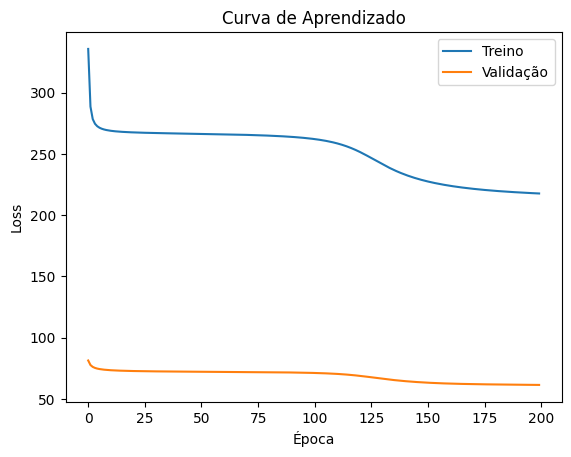

In [10]:
plt.plot(losses_treino, label='Treino')
plt.plot(losses_validacao, label='Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Aprendizado')
plt.legend()
plt.show()

Isto acontece pois há mais dados der treino que de validação.
Se quisermos ver em relação ao número de exemplos, teremos resultados mais intepretáveis:

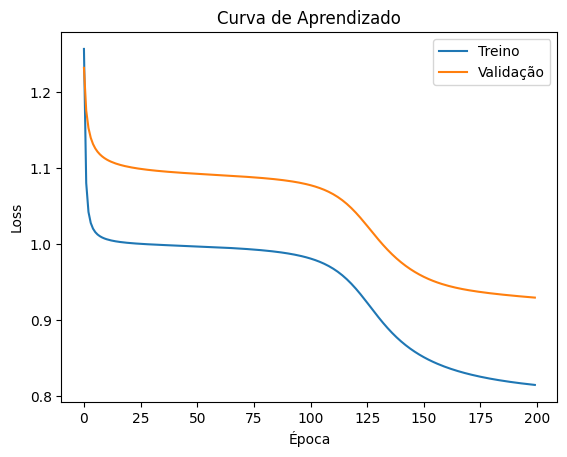

In [ ]:
losses_treino_ = [loss/len(x_treino) for loss in losses_treino]
losses_val_ = [loss/len(x_validacao) for loss in losses_validacao]
plt.plot(losses_treino_, label='Treino')
plt.plot(losses_val_, label='Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Aprendizado')
plt.legend()
plt.show()

### Conclusão:
Podemos observar, que o comportamento da curva é bem semelhante, o que sugere que o aprendizado da rede ocorreu da forma esperada pois: 

- A perda inicia alta por conta da aleatoriedade dos pesos e se ajusta posteriormente.
- A perda, podemos perceber que é sempre menor nos dados de treino, pois é a partir deles que é treinado o modelo, e os parâmetros são ajustados para ele.
- A perda dos dados de validação continua decrescente durante todo treinamento mesmo com o alto número de épocas, o que sugere que não há overfitting. 

A análise da curva de perda de dados de treino e validação é essencial para analisarmos se há overfitting no modelo. Os dados estão normalizados, o que explica a escala da perda.